<a href="https://colab.research.google.com/github/s-c-soma/AlternusVera/blob/master/Factor_NewsCoverage_ScoreComputing_wk2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This NoteBook Is Part of the Ongoing Alterus Vera Assignment

<h1>Alternus Vera - Final Version - Hyunwook Shin</h1>

November 25, 2018
012507417

Link to the main group notebook from previous week(s):

https://colab.research.google.com/drive/1bOoY6V0ytxSigKuZ6lJntNWJJcTM_6wU#scrollTo=ebnN4ikZzQtu

## Subarna Chowdhury Soma

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1 Introduction

I will be focusing on the factor **news coverage** to identify  which if a news story is genuine or fake news, as shown below:

| Factor | Explanation|
| -- | -- |
| Coverage of the latent event from outside sources  | Level of coverage regarding the latent story or topic  | 


The news coverage is the factor I put my most personal effort in, covering all areas of distillation (preprocessing, LDA, sentiment analysis)


### 1.2 Contribution - Notebook

The following notebook is prepared by Subarna Chowdhury Soma. 

### 1.3 Definitions

We shall define the  following terms as follows:

* **coverage**  - number of news from media outlet that covered the same event or latent topic depicted in the article, within a fixed time window. There is a fixed window of time 1 month (coverage 30) and 2 months (coverage 60) before and after the article was published.







## 2 Design Approach

I shall try all the distillation approach on liar liar data set first and then on all news data set. Then I shall perform LDA to to identify topics with score. Next plan is comparing the topic stories between liar liar and all news data set. Most important task is computing news coverage score. Final implementation identifying best fit classification model through auto ML. Best performed classification will be applied on liar liar dataset, kaggle all news dataset and combined data set after amalgamation. 

### 2.1  Scope

After the necessary distillation , the goal is to create approximate scores for news coverage.

To summarize the document will focus on:

1. Introduction
2. Methods and Approaches
3. Importing Data including Data Enrichment
4. Other Preliminary Requirements
5. Distillation Function Code Reuse and Refactored Code
6. Topic Modeling and LDA Analysis
7. New Coverage Factor using Word2Vec and Random Forrest Classifier


 ### 2.2 News Coverage
 * **Coverage** We first use topic modeling to find the key latent topics. Then we use a separate dataset called "All the news" dataset to see if there are other  articles covering a similar story. It is important to note that we are *not* cross-checking factual claims made in the article, but rather checking to see if a related and latent topic can be found in other news sources. If there are no external coverage for the story/topic, chances are that the article in question is likely a fake news. However, just because there are sufficient coverage during the time frame, it does not necessarily mean that the news is completely reliable.
  


### 2.3 Alternative Methods Tried



As a team we collected financial news data using API from Newyork Times and Reddit News for our first Machine Learning project. At first I tried to use that news collection, but that dataset has only two news source. For news coverage I need a data set with multiple source covering the same story. Later I have found Kaggle "All News" dataset which contains news of various domain from 15 news sources. So I am proceeding with Kaggle dataset for data enrichment and amalgamation.



## 3 Data Preprataions


### 3.1 Import Libraries

In [0]:
# For caculating approximate time to process notebook (IGNORE)
import datetime
datetime.datetime.now()

datetime.datetime(2020, 4, 26, 21, 50, 47, 363038)

In [0]:
from nltk.corpus import stopwords
from string import punctuation

import pandas as pd
import nltk
import io
import requests
import re

# download nltk stopwords
nltk.download('stopwords')
nltk.download('wordnet')




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
import argparse
import pandas as pd
import numpy as np
import operator
import matplotlib.pyplot as plt
import nltk as nl
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.model_selection import ParameterGrid
import statistics
import random
import warnings
from string import punctuation
from matplotlib import pyplot
from pandas import Series, datetime
from pandas.plotting import scatter_matrix, autocorrelation_plot
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
import nltk
import re
import io
import requests
import time
import gensim
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk.sentiment

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('vader_lexicon')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

### 3.2 Data Load: Liar Liar Dataset

For the purpose of this study, we will focus on the Kaggle's Liar Dataset (Risdal, 2016) The main benefit of Kaggle's Liar Dataset is the text entry that is included with the headline.

https://github.com/synle/machine-learning-sample-dataset/raw/master/liar_dataset/kaggle

In [0]:
def get_parsed_data(url, sep='\t', header=None ):
  return pd.read_csv(io.StringIO(requests.get(url).content.decode('utf-8')), sep=sep, header=header )

# Download and parse the dataset... Let us first work with 100 articles
KAGGLE_DATASET = 'https://github.com/synle/machine-learning-sample-dataset/raw/master/liar_dataset/kaggle'
data_liar_liar = get_parsed_data('%s/kaggle-fake.csv'% KAGGLE_DATASET, ',' , 'infer' )[:1000]

In [0]:
data_liar_liar.head(1)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias


### 3.3 Data Load: Kaggle All News Dataset

We have use two main datasets to be used for data enrichment:

**Dataset 1** - All The News (Thompson, 2017)
- Original: https://www.kaggle.com/snapcrack/all-the-news
- Github Link: https://github.com/hyunwookshin/all_news_dataset_kaggle

The above data is useful for analyzing coverage report of non-fake news articles
curated from mainstream news media sites.



In [0]:
# All News Kaggle

def get_parsed_data2(url):
    return pd.read_csv(io.StringIO(requests.get(url, verify=False).content.decode('utf-8')), sep=',', header='infer')

# download and parse the dataset from github
data_all_news = get_parsed_data2('https://media.githubusercontent.com/media/hyunwookshin/all_news_dataset_kaggle/master/articles1.csv')

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


## 4 Distillation - Liar Liar Data

### 4.1 Tokenization

As part of the distillation, we tokenize the headline and the body of the articles, by the following methods. First the words are split based on the white space. We also use this step to combine the title with the body of the article.





In [0]:
data_liar_liar['text_distilled'] = data_liar_liar['title'].apply(lambda x : re.split('\W+', str(x).lower())) +\
   data_liar_liar['text'].apply(lambda x : re.split('\W+', str(x).lower()))
data_liar_liar.head(1)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,text_distilled
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,"[muslims, busted, they, stole, millions, in, g..."


In [0]:
data_liar_liar.text_distilled[0][:25]

['muslims',
 'busted',
 'they',
 'stole',
 'millions',
 'in',
 'gov',
 't',
 'benefits',
 'print',
 'they',
 'should',
 'pay',
 'all',
 'the',
 'back',
 'all',
 'the',
 'money',
 'plus',
 'interest',
 'the',
 'entire',
 'family',
 'and']

### 4.2 Lemmatization
  
First, the raw words must be converted to root forms.  The words are converted to their root stems based on the following using lemmaitization. Stemming using nltk.PorterStemmer was used previously, but eventually dropped due to its method of dropping suffixes without correction to the root stem. For example, stemming resulted in non-existent words such as 'plu',  'interest',  'entir',  'famili',  'everyon'.

In [0]:
def lemmatize(tokenized_words):
  text = [nltk.WordNetLemmatizer().lemmatize(word) for word in tokenized_words]
  return text

# Commented out per rationale above
#def stemming(tokenized_words):
#  text = [nltk.PorterStemmer().stem(word) for word in tokenized_words]
#  return text

data_liar_liar['text_distilled_lemma'] = data_liar_liar['text_distilled'].apply(lemmatize)
data_liar_liar.text_distilled[0][:15]

['muslims',
 'busted',
 'they',
 'stole',
 'millions',
 'in',
 'gov',
 't',
 'benefits',
 'print',
 'they',
 'should',
 'pay',
 'all',
 'the']

### 4.3 Removing Stop words

Let us remove stop words, which are absolutely critical in determining keywords indicative of timed event.

In [0]:
english_stopwords = set(stopwords.words('english') + list(punctuation) + [''])

def remove_stopwords(tokenized_words):
  text = [word for word in tokenized_words if word not in english_stopwords]
  return text

data_liar_liar['text_distilled'] = data_liar_liar['text_distilled'].apply(remove_stopwords)
data_liar_liar.text_distilled[0][:15]

['muslims',
 'busted',
 'stole',
 'millions',
 'gov',
 'benefits',
 'print',
 'pay',
 'back',
 'money',
 'plus',
 'interest',
 'entire',
 'family',
 'everyone']

### 4.4 Custom Filtering

One or two-letter words from the tokenized words are also removed to further cleanse the raw text. First, two-letter words are chosen one by one (there are roughly 100 to 150 words, plus some common country codes). Each word, is examined whether it is worth keeping. Of course, there are more two-letter words than the whitelist shown below, but many of them (e.g. so, am, it) are already eliminated using stop words. If we build a dictionary of all these non-trivial words that are two-letters long, this will help improve the accuracy of the model.

In [0]:
whitelist = set(['ai', 'ax', 'ca', 'eu', 'go', 'io', 'la', 'ox', 'us', 'uk', 
                 'al', 'ak', 'az', 'ar', 'ca', 'co', 'ct', 'de', 'fl', 'ga', 'hi', 
                 'id', 'il', 'in', 'ia', 'ks', 'ky', 'la', 'me', 'md', 'ma', 'mi',
                 'mn', 'ms', 'mo', 'mt', 'ne', 'nv', 'nh', 'nj', 'nm', 'ny',
                 'nc', 'nd', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn',
                 'tx', 'ut', 'vt', 'va', 'wa', 'wv', 'wi', 'wy' ])
def remove_too_short(tokenized_words):
  text = [word for word in tokenized_words if (len(word) >= 3 or word not in whitelist) ]
  return text

In [0]:
data_liar_liar['text_distilled'] = data_liar_liar['text_distilled'].apply(remove_too_short)
data_liar_liar.text_distilled[0][:15]

['muslims',
 'busted',
 'stole',
 'millions',
 'gov',
 'benefits',
 'print',
 'pay',
 'back',
 'money',
 'plus',
 'interest',
 'entire',
 'family',
 'everyone']

## 5 Topic Modeling - Liar Liar Data

### 5.1 LDA Analysis


In [0]:
! pip install gensim

In [0]:
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

def topics(tokenized_words):
    d = Dictionary([tokenized_words])
    c = [d.doc2bow(tokenized_words)]
    m = LdaModel(c, num_topics=1, id2word=d)
    return list(m.print_topics(num_words=2))
  
data_liar_liar['topics'] = data_liar_liar['text_distilled'].apply(topics)


Let us analyze the topics of some sample articles:

In [0]:
data_liar_liar.title[1],data_liar_liar.topics[1]

('Re: Why Did Attorney General Loretta Lynch Plead The Fifth?',
 [(0, '0.033*"lynch" + 0.020*"attorney"')])

In [0]:
data_liar_liar.title[2],data_liar_liar.topics[3]

('BREAKING: Weiner Cooperating With FBI On Hillary Email Investigation',
 [(0, '0.049*"speech" + 0.037*"donald"')])

In [0]:
data_liar_liar.title[3],data_liar_liar.topics[3]

('PIN DROP SPEECH BY FATHER OF DAUGHTER Kidnapped And Killed By ISIS: "I have voted for Donald J. Trump!" » 100percentfedUp.com',
 [(0, '0.049*"speech" + 0.037*"donald"')])

In [0]:
data_liar_liar.title[4],data_liar_liar.topics[4]

("FANTASTIC! TRUMP'S 7 POINT PLAN To Reform Healthcare Begins With A Bombshell! » 100percentfedUp.com",
 [(0, '0.022*"insurance" + 0.016*"must"')])

In [0]:
len(data_liar_liar.title)

1000

### 5.2 Topics as Simple List of Words

A list of topic terms is compiled as show below. The coefficients in front of each word are dropped as part of simplification. The assumption is that the top two words comprising the topic, are both significant enough to be treated equally. It is important that the goal is to build a reliable prediction model. While there is a risk of oversimplification, if the final model results in a poor accuracy score, the coefficient can always be reintroduced here.

In [0]:
def parseTopics(topics):
   output = []
   words = topics[0][1].split( '+' )
   for word in words:
       output.append( word.split('*')[1].replace( '"', '' ) )
   return output

data_liar_liar['topics'] = data_liar_liar['topics'].apply(parseTopics)

In [0]:
data_liar_liar.title[1],data_liar_liar.topics[1]

('Re: Why Did Attorney General Loretta Lynch Plead The Fifth?',
 ['lynch ', 'attorney'])



## 6 Data Enrichment and Visual Analysis

The notebook uses Kaggle's "All the news" dataset to curate reference articles to enrich the study of coverage analysis  (Thompson,  2017).



Since "articles1.csv" was sufficient to get a good coverage analysis. The data from articles2.csv and articles3.csv were dropped. Including all data unnecesarily, can result in slow distillation, training and testing.

In [0]:
#data_all_news = pd.read_csv('/content/drive/My Drive/Colab Notebooks/articles1.csv', low_memory =False, encoding = "ISO-8859-1")
#data_all_news.head(20)

### 6.1 Article Count by News Sources


Article counts by publisher:
Breitbart           23781
CNN                 11488
New York Times       7803
Business Insider     6757
Atlantic              171
Name: publication, dtype: int64


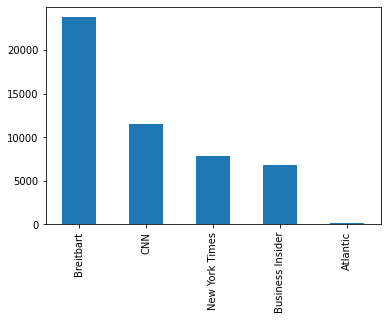

In [0]:
print("\nArticle counts by publisher:")
s= data_all_news['publication'].value_counts()
print(s)
s.plot(kind='bar')

### 6.2 Article Count by Date


Article counts by date:
2016-08-22    221
2017-04-13    187
2017-04-14    180
2017-02-03    172
2017-04-07    169
             ... 
2015-12-23      1
2013-02-07      1
2014-01-10      1
2013-05-20      1
2013-04-12      1
Name: date, Length: 983, dtype: int64


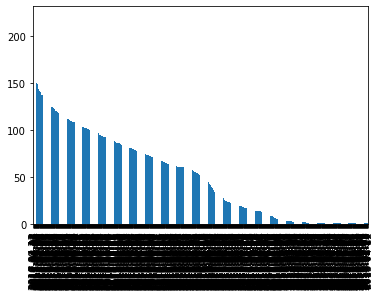

In [0]:
print("\nArticle counts by date:")
s= data_all_news['date'].value_counts()
print(s)
s.plot(kind='bar')

## 7 Distillation - Kaggle All News Dataset

### 7.1 Cleansing "All News" Articles and Finding Document Similarity

For each article, the goal is to count all relevant articles in the data_all_news dataset that contain similar topics. To achieve this, we also need to do a latent topic modelling.



### 7.2 Distillation - Tokenization

In [0]:
data_all_news['text_distilled'] = data_all_news['title'].apply(lambda x : re.split('\W+', str(x).lower())) +\
   data_all_news['content'].apply(lambda x : re.split('\W+', str(x).lower()))

### 7.3 Distillation - Lemmatization

In [0]:
data_all_news['text_distilled'] = data_all_news['text_distilled'].apply(lemmatize)

### 7.4 Distillation - Stop Words

In [0]:
data_all_news['text_distilled'] = data_all_news['text_distilled'].apply(remove_stopwords)

### 7.5 Distillation - Additional

In [0]:
data_all_news['text_distilled'] = data_all_news['text_distilled'].apply(remove_too_short)
data_all_news.text_distilled[0][:15]

['house',
 'republican',
 'fret',
 'winning',
 'health',
 'care',
 'suit',
 'new',
 'york',
 'time',
 'washington',
 'congressional',
 'republican',
 'new',
 'fear']

## 8 Topic Modeling - All News Data

### 8.1 Topic Analysis - Running LDA to Extract Topics

In [0]:
data_all_news['topics'] = data_all_news['text_distilled'].apply(topics)

In [0]:
data_all_news['topics'] = data_all_news['topics'].apply(parseTopics)

Making sure that the distillation is succesful, the following snippet was run.

In [0]:
data_all_news.title[0], data_all_news.topics[0]

('House Republicans Fret About Winning Their Health Care Suit - The New York Times',
 ['house ', 'republican'])

## 9 News Coverage Computation

### 9.1 Scoring Coverage (Ranking)

The latent topics are parsed from non-fake news datset. To make an appropriate scoring coverage, the latent topics between "all news" data set and fake news dataset (`data_liar_liar`) are compared.

In [0]:
def setDate( published ):
   return published.split( "T" )[0]

data_liar_liar[ 'date' ] = data_liar_liar.published.apply( setDate )

In [0]:
data_liar_liar.head(1)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,text_distilled,text_distilled_lemma,topics,date
0,6a175f46bcd24d39b3e962ad0f29936721db70db,0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,english,2016-10-27T01:49:27.168+03:00,100percentfedup.com,US,25689.0,Muslims BUSTED: They Stole Millions In Gov’t B...,0.0,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,0,1,0,0,0,bias,"[muslims, busted, stole, millions, gov, benefi...","[muslim, busted, they, stole, million, in, gov...","[benefits , government]",2016-10-26


The coverage window is simply a time-range where two articles are considered to be pushed in the same approximate "time frame". Narrowing the window size will result in low coverage score across all rows. Increasing the window size will result in high coverage score across all rows. The choice of the window size was arbitrary (30 days). Please see section 7.17 for 60-day coverage window.

In [0]:
import datetime

def window( datestring, n ):
   d = datetime.datetime.strptime( datestring, "%Y-%m-%d" )
   delta = datetime.timedelta(days=n)
   fromdate = datetime.datetime.strftime(d - delta, "%Y-%m-%d")
   todate = datetime.datetime.strftime(d + delta, "%Y-%m-%d")
   return ( fromdate, todate )

Please note that coverage scoring below can take about 10~15 minutes to complete (With GPU Hardware accelerator).

In [0]:
import datetime

print( "Start Time", datetime.datetime.now() )

def coverage( article ):
   fromdate, todate = window( article[ 'date' ], 15 )
   selected_coverage = data_all_news[(data_all_news['date'] > fromdate) & (data_all_news['date'] < todate)]
   selected_coverage['covered'] = selected_coverage.apply( lambda r: r[ 'topics' ][0] in article.topics and
                                                       r[ 'topics' ][1] in article.topics, axis=1 )
   return len(selected_coverage[selected_coverage['covered'] == True])

data_liar_liar[ 'coverage' ] = data_liar_liar.apply( coverage, axis=1 )

print( "Finished Time", datetime.datetime.now() )

Start Time 2020-04-26 21:56:12.393230


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


Finished Time 2020-04-26 21:58:12.958054


In [0]:
data_liar_liar.sort_values(by=['coverage'], ascending=False ).head(5)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,text_distilled,text_distilled_lemma,topics,date,coverage
53,a36405a8d7d32c2192b9a9b482dcf0ebc83c62eb,0,Mike Rivero,2016-11-23T00:49:00.000+02:00,FLASHBACK - Hillary Clinton’s ‘KKK’ Smear Agai...,"November 21, 2016 By 21wire Leave a Comment \n...",english,2016-11-23T01:36:58.899+02:00,21stcenturywire.com,US,NaN,FLASHBACK - Hillary Clinton’s ‘KKK’ Smear Agai...,0.0,http://i2.wp.com/21stcenturywire.com/wp-conten...,0,1,0,0,0,conspiracy,"[flashback, hillary, clinton, kkk, smear, trum...","[flashback, hillary, clinton, s, kkk, smear, a...","[mr , trump]",2016-11-23,40
26,c1a86b752a21196a06591d5a785fa29b14fab245,0,EdJenner,2016-11-22T08:17:53.961+02:00,DONALD TRUMP Calls Meeting With Press…Dresses ...,Go to Article \nThey had to know they had it c...,english,2016-11-22T08:17:53.961+02:00,100percentfedup.com,US,25689.0,DONALD TRUMP Calls Meeting With Press…Dresses ...,0.0,http://conservativeangle.com/wp-content/upload...,0,1,0,0,0,bias,"[donald, trump, calls, meeting, press, dresses...","[donald, trump, call, meeting, with, press, dr...","[trump , said]",2016-11-22,22
988,b2e81b8debd3ca29f942d34b781126c07e427194,0,NaN,2016-10-28T18:40:18.626+03:00,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",Email \n\nIt appears Bill and Hillary Clinton ...,english,2016-10-28T18:40:18.626+03:00,awdnews.com,DE,NaN,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",0.0,http://awdnews.com/images/14776680451.jpg,0,0,0,0,0,conspiracy,"[fear, trump, bush, obama, clinton, buying, pr...","[fear, of, trump, bush, obama, clinton, all, b...","[trump , clinton]",2016-10-28,20
980,29aa6e6c0aa6e47a2ee80e18b8ddc031657425b0,0,NaN,2016-10-28T18:34:48.985+03:00,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",Email \n\nIt appears Bill and Hillary Clinton ...,english,2016-10-28T18:34:48.985+03:00,awdnews.com,DE,NaN,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",0.0,http://awdnews.com/images/14776680451.jpg,0,0,0,0,0,conspiracy,"[fear, trump, bush, obama, clinton, buying, pr...","[fear, of, trump, bush, obama, clinton, all, b...","[trump , clinton]",2016-10-28,20
631,7e8e053bbe2ed4978c6b8a69c58fb0441fd4cbf8,0,Alex Ansary,2016-10-31T19:54:37.665+02:00,Get Ready For Civil Unrest,Get Ready For Civil Unrest 10/31/2016 \nECONOM...,english,2016-10-31T19:54:37.665+02:00,amtvmedia.com,US,NaN,Get Ready For Civil Unrest,0.0,http://www.amtvmedia.com/wp-content/uploads/20...,0,1,0,0,0,bs,"[get, ready, civil, unrest, get, ready, civil,...","[get, ready, for, civil, unrest, get, ready, f...","[trump , clinton]",2016-10-31,18


In [0]:
data_liar_liar.sort_values(by=['coverage'], ascending=False ).head(1)['title'], data_liar_liar.sort_values(by=['coverage'], ascending=False ).head(1)['coverage']

(53    FLASHBACK - Hillary Clinton’s ‘KKK’ Smear Agai...
 Name: title, dtype: object, 53    40
 Name: coverage, dtype: int64)

### 9.2 Intermediary Analysis

**Label Pairing** - For now,  top two words of the topics are chosen in the all-news dataset, as "labels." Then using the topics of each fake news datasets and number all-news articles corresponding to each fake news article can be deduced. This means that for every article, we are searching for related articles. 

<i>Hypothetical Label Pairing for Illustration Purposes</i>

Table A (10 articles)

|  Articles | Topic Words | Computed Coverage Score | Rationale |
| -- | -- | -- |
|  1            | "Apple", "Banana" | 0 | Matches None from B |
|  2            | "Apple", "Orange" | 1 |  Matches B.2 |
|  3            | "Orange", "Pear" | 2 | Matches B.3 and B.1023 | 
| ... | ... |

Table B (10,000 articles)

|  Articles | Topic Words |
| -- | -- |
|  1            | "Apple", "Pear" |
|  2            | "Apple", "Orange" |
|  3            | "Orange", "Pear" |
| ... | ... |
|  1023      | "Orange", "Pear" |
| ... | ... | 

**Building a Model** This "search" part should only be done during training stage, but not during testing and validation stages. But manually searching each row in the database is expensive and unscalable. Also, if the model simply looks up in internal database and return the score, it is more or less a search solution, not a Machine Learning Classification solution.

Instead of doing this search for every article, the model should predict how much coverage it is likely to have based on the top two **topic terms** and the **date** of publication with classifiers such as Naive Bayes or Decision Trees. Clearly it will require lot of articles for training since there will be a rich set of topic terms and dates resulting in wide range of coverage scores.

**Risks** There is some risk involved with this approach. Sometimes LDA and topic modeliing doesn't get us far enough. Sometimes the keywords generated by LDA such as "Car", "Bus", "Train" all have the latent super-topic called "transporation".  So in our distillation not only we should filter out stop words and run lemmatization, we should condense the words even further such as "transportation".  This will require additional data enrichment.

### 9.3 Using word2vec to Convert Topics to Vector Embeddings

We use word2vec to fit the entire text from all articles, and then use word2vec model to convert the topic words to vectors.

In [0]:
from gensim.models import Word2Vec

m = Word2Vec( data_liar_liar[ 'text_distilled' ] )

In [0]:
m.similarity( 'clinton', 'hillary' )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.9519738

In [0]:
m.similarity( 'trump', 'election' )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.91784376

In [0]:
import numpy as np

def encodeFirstColumn( topics ):
   topic = topics[0].strip()
   if topic in m:
      return m[topic].tolist()
   else:
      return np.zeros( len(m[list(m.wv.vocab)[0]]) ).tolist()
   
data_liar_liar[ 'topic_0' ] = data_liar_liar.topics.apply( encodeFirstColumn )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


Running few sanity check, to ensure that the computation is correct,

In [0]:
'clinton' in m

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  """Entry point for launching an IPython kernel.


True

In [0]:
m['hillary']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.0599088 , -0.97712165, -0.33149233,  1.1108931 ,  0.11399562,
        0.6917598 ,  0.5112789 , -0.25123584, -0.5300881 ,  0.38260257,
        0.1821977 ,  1.0706582 , -0.00396733,  1.0379264 , -0.06480514,
        0.24194996, -1.2670025 , -0.51812637,  0.11837752,  0.10562477,
        0.6940386 ,  0.78001827,  0.6254942 , -0.2094347 ,  0.30939117,
       -0.88949007,  0.72241485, -0.7014536 ,  0.564195  , -0.73133725,
        0.06339596, -0.5998616 , -0.20668285, -1.054493  , -0.11538505,
        0.17136377, -0.8302145 , -0.08438726,  0.7809369 ,  0.11137526,
        0.57130104, -0.27530664,  0.11645808, -0.54301363, -0.29800457,
        0.04329969,  0.47702023,  0.14929795,  0.580978  ,  0.30415824,
        0.677182  ,  0.532742  , -0.11449214, -0.06657296,  0.75497067,
       -0.88685685, -0.42305097,  1.6851673 ,  0.6041486 ,  0.00352517,
        0.969027  , -0.7568369 , -0.1610659 , -0.08246683,  0.14363894,
       -0.55895394, -0.54401696, -0.21093756,  0.09587236, -0.03

In [0]:
data_liar_liar[ 'topic_0' ][:10]

0    [0.025042792782187462, -0.12144271284341812, -...
1    [0.034862734377384186, -0.15848812460899353, -...
2    [0.048918649554252625, -0.2565712630748749, -0...
3    [0.04704653099179268, -0.2691696882247925, -0....
4    [0.03806588426232338, -0.1565510779619217, -0....
5    [0.054349374026060104, -0.8435940742492676, -0...
6    [0.031533438712358475, -0.1338760107755661, -0...
7    [0.033910833299160004, -0.31178390979766846, -...
8    [0.054349374026060104, -0.8435940742492676, -0...
9    [-0.2817469835281372, -0.7827937006950378, -0....
Name: topic_0, dtype: object

In [0]:
def assertDim( topic_vec ):
   assert len(topic_vec) == len(m[list(m.wv.vocab)[0]]) and len(topic_vec) > 0
    
def assertType( topic_vec ):
   assert isinstance(topic_vec, list)
    
data_liar_liar.topic_0.apply( assertDim )[0]
data_liar_liar.topic_0.apply( assertType )[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


The second topic term is also encoded into word2vec vector.

In [0]:
import numpy as np

vector_dim = len(m[list(m.wv.vocab)[0]])

def encodeSecondColumn( topics ):

   if len( topics ) > 1 :
      topic = topics[1].strip()
   else:
      return np.zeros( len(m[list(m.wv.vocab)[0]]) ).tolist()
   if topic in m:
      return m[topic].tolist()
   else:
      return np.zeros( len(m[list(m.wv.vocab)[0]]) ).tolist()
   
data_liar_liar[ 'topic_1' ] = data_liar_liar.topics.apply( encodeSecondColumn )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: DeprecationWarn

In [0]:
data_liar_liar.topic_1.apply( assertDim )[0]
data_liar_liar.topic_1.apply( assertType )[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


### 9.4 Sentiment Analysis

Sentiment analysis has been done on the Kaggle data set, from 
(Martin et. al, n.d)

In [0]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sia = SentimentIntensityAnalyzer()

def getSentiment( text ):
    return sia.polarity_scores(text)
  
data_liar_liar[ 'text_distilled_joined' ] = data_liar_liar[ 'text_distilled' ].apply( lambda x : ' '.join(x) ) 
data_liar_liar[ 'sentiment' ] = data_liar_liar.text_distilled_joined.apply( getSentiment )

print(data_liar_liar['sentiment' ][:10] )

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
0    {'neg': 0.135, 'neu': 0.669, 'pos': 0.196, 'co...
1    {'neg': 0.129, 'neu': 0.815, 'pos': 0.057, 'co...
2    {'neg': 0.051, 'neu': 0.791, 'pos': 0.158, 'co...
3    {'neg': 0.3, 'neu': 0.46, 'pos': 0.24, 'compou...
4    {'neg': 0.093, 'neu': 0.722, 'pos': 0.185, 'co...
5    {'neg': 0.356, 'neu': 0.591, 'pos': 0.053, 'co...
6    {'neg': 0.135, 'neu': 0.723, 'pos': 0.142, 'co...
7    {'neg': 0.193, 'neu': 0.735, 'pos': 0.072, 'co...
8    {'neg': 0.066, 'neu': 0.842, 'pos': 0.093, 'co...
9    {'neg': 0.152, 'neu': 0.792, 'pos': 0.056, 'co...
Name: sentiment, dtype: object


### 9.5 Converting Dates to Numeric Format

The date column with format YYYY-MM-dd is converted into YYYYMM  (where MM is month, and YYYY) is year. Specific day of the months is dropped to avoid overfitting.



In [0]:
def setNumericDate( date ):
   y, m, d = date.split( "-" )
   return int(y + m)

data_liar_liar[ 'date_int' ] = data_liar_liar.date.apply( setNumericDate )

In [0]:
data_liar_liar[ 'date_int' ][0]

201610

### 9.6 Using Ranfom Forrest Classifier

Using the numeric (integer) dates, and two vectors (for top two topics chosen), a random forrest classifier is trained.

In [0]:
# First split the vectors of word2vec into individual columns

X_prep = data_liar_liar[[ 'date_int', 'topic_0', 'topic_1' ]]

def select(topic_vec, idx):
   return topic_vec[idx]

prep_dict = { "date_int" : [] }
for i in range( vector_dim*2 ):
   prep_dict[str(i)] = []
    
X_COV = pd.DataFrame(prep_dict)
X_COV[ 'date_int' ] = X_prep[ 'date_int' ]

vector_dim = len(m[list(m.wv.vocab)[0]])

for i in range( vector_dim ):
   X_COV[str(i)] = X_prep.topic_0.apply( lambda x : select(x, i ) )
    
X_COV.head(1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


,date_int,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,201610,0.025043,-0.121443,-0.099447,0.156816,0.060435,0.107782,0.099665,-0.061972,-0.096245,-0.07746,0.123857,0.204427,0.016171,0.215412,-0.061573,-0.149496,-0.259554,-0.085291,0.061669,0.168995,0.185546,0.2333,0.092781,-0.288679,-0.028718,-0.088788,0.165422,-0.229747,0.248202,-0.017613,-0.148975,-0.05686,0.042416,-0.066049,-0.091488,0.141349,-0.15786,0.176083,0.11511,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
for i in range( vector_dim ):
   X_COV[str(vector_dim + i)] = X_prep.topic_1.apply( lambda x : select(x, i ) )

In [0]:
X_COV.head(1)

,date_int,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,201610,0.025043,-0.121443,-0.099447,0.156816,0.060435,0.107782,0.099665,-0.061972,-0.096245,-0.07746,0.123857,0.204427,0.016171,0.215412,-0.061573,-0.149496,-0.259554,-0.085291,0.061669,0.168995,0.185546,0.2333,0.092781,-0.288679,-0.028718,-0.088788,0.165422,-0.229747,0.248202,-0.017613,-0.148975,-0.05686,0.042416,-0.066049,-0.091488,0.141349,-0.15786,0.176083,0.11511,...,-0.087095,-0.864928,-0.439669,-0.34808,0.225125,0.101256,-0.809845,-0.140057,-0.152042,0.036886,0.335061,-0.072041,0.49091,-0.279214,0.40089,0.134645,0.173381,0.291186,-0.45788,-0.270166,-0.228812,0.013073,0.156398,-0.620183,0.203903,-0.08053,-0.507087,-0.630622,0.204406,-0.103502,-0.033246,0.405595,-0.982143,-0.14774,0.514802,0.024501,-0.360176,0.305508,0.777202,0.198004


The following code creates training and test data.

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

Y_COV = data_liar_liar[ 'coverage' ]
X_train, X_test, y_train, y_test = train_test_split(X_COV, Y_COV, test_size=0.33, random_state=42)
print("train:" , X_train.shape)
print("test:" , X_test.shape)

train: (670, 201)
test: (330, 201)


In [0]:
X_COV.head(3)

,date_int,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,201610,0.025043,-0.121443,-0.099447,0.156816,0.060435,0.107782,0.099665,-0.061972,-0.096245,-0.077460,0.123857,0.204427,0.016171,0.215412,-0.061573,-0.149496,-0.259554,-0.085291,0.061669,0.168995,0.185546,0.233300,0.092781,-0.288679,-0.028718,-0.088788,0.165422,-0.229747,0.248202,-0.017613,-0.148975,-0.056860,0.042416,-0.066049,-0.091488,0.141349,-0.157860,0.176083,0.115110,...,-0.087095,-0.864928,-0.439669,-0.348080,0.225125,0.101256,-0.809845,-0.140057,-0.152042,0.036886,0.335061,-0.072041,0.490910,-0.279214,0.400890,0.134645,0.173381,0.291186,-0.457880,-0.270166,-0.228812,0.013073,0.156398,-0.620183,0.203903,-0.080530,-0.507087,-0.630622,0.204406,-0.103502,-0.033246,0.405595,-0.982143,-0.147740,0.514802,0.024501,-0.360176,0.305508,0.777202,0.198004
1,201610,0.034863,-0.158488,-0.126565,0.196907,0.080541,0.146720,0.130974,-0.062513,-0.108782,-0.090138,0.142309,0.255376,0.018865,0.271053,-0.072114,-0.169061,-0.333481,-0.098070,0.073148,0.222384,0.226671,0.297666,0.133300,-0.345517,-0.033324,-0.115661,0.217786,-0.273265,0.304744,-0.030108,-0.177481,-0.075690,0.041086,-0.098668,-0.120805,0.169313,-0.208629,0.215508,0.154352,...,0.050810,-0.640058,-0.367323,-0.250560,0.151082,-0.006427,-0.614438,-0.127251,-0.112264,0.066890,0.228016,-0.064974,0.395775,-0.170087,0.310019,0.106024,0.115219,0.228309,-0.263943,-0.069295,-0.141103,-0.073947,0.019922,-0.541671,0.255904,-0.067499,-0.389666,-0.549661,0.199105,-0.001340,-0.114225,0.375148,-0.723621,-0.199811,0.389354,0.090900,-0.167742,0.232540,0.579263,0.164115
2,201610,0.048919,-0.256571,-0.183650,0.322264,0.115145,0.219703,0.215043,-0.091088,-0.167442,-0.090716,0.202534,0.385090,0.029202,0.393930,-0.096492,-0.199592,-0.503480,-0.160904,0.096384,0.285285,0.337931,0.420299,0.193337,-0.469754,-0.015528,-0.203934,0.327954,-0.389238,0.411272,-0.071271,-0.230833,-0.136001,0.032094,-0.183609,-0.176624,0.221225,-0.328063,0.275475,0.224849,...,0.055382,-0.439216,-0.258319,-0.174224,0.104584,-0.011238,-0.418532,-0.078008,-0.091604,0.042735,0.162714,-0.053712,0.264512,-0.111208,0.208892,0.083127,0.088776,0.163216,-0.168945,-0.035446,-0.094434,-0.067501,0.005808,-0.366532,0.179507,-0.038770,-0.265481,-0.376988,0.136494,-0.006458,-0.082948,0.278230,-0.496057,-0.157032,0.265370,0.075463,-0.111534,0.156726,0.405270,0.109867


In [0]:
f_cov = RandomForestClassifier(n_estimators=10)
f_cov.fit(X_train, y_train)
y_pred = f_cov.predict(X_test)

Predicting the accuracy of the coverage,

In [0]:
from sklearn import metrics

'Accuracy', metrics.accuracy_score(y_test, y_pred)

('Accuracy', 0.9333333333333333)

### 9.7 AutoML

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
num_folds = 10
seed = 7
scoring = 'accuracy'

models = []
models.append(('LR' , LogisticRegression()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
#models.append(('KNN' , KNeighborsClassifier()))
#models.append(('CART' , DecisionTreeClassifier()))
#models.append(('NB' , GaussianNB()))
#models.append(('SVM' , SVC()))
#models.append(('MNB', MultinomialNB()))
models.append(('RF' , RandomForestClassifier(n_estimators=50)))
#models.append(('XGBoost', XGBClassifier()))

In [0]:
results = []
names = []

'''
for name, model in models:
  kfold = KFold(n_splits=num_folds, random_state=42)
  cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
  results.append(cv_results)
  names.append(name)
  msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
  print(msg) '''

for name, model in models:
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accu_score = accuracy_score(y_test, y_pred)
    print(name + ": " + str(accu_score))

LR: 0.9090909090909091
LDA: 0.7757575757575758
RF: 0.9363636363636364


The accuracy based on the unseen test data is 90%~95%. This means that using the word2vec-based model one can build a reliable coverage score.

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
No handles with labels found to put in legend.


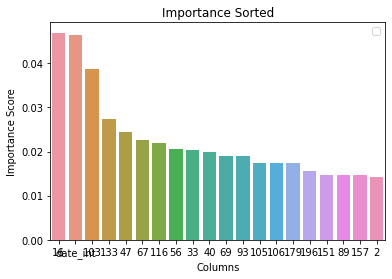

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns

importantCols = pd.Series(f_cov.feature_importances_,index=list(X_COV)).sort_values(ascending=False)
sns.barplot(y=importantCols[:20], x=importantCols.index[:20])

plt.ylabel('Importance Score')
plt.xlabel('Columns')
plt.title("Importance Sorted")
plt.legend()
plt.show()

### 9.8 Interpretation

As shown above "`date_int`"  is one of the most important feature in determining whether or not the news has high news coverage. This is expected since the date the news has been posted definitely impacts on whether the news has sufficient coverage from peer articles. Some of the numeric (word2vec) columns  have significant impact on the prediction of the coverage score. But, since these factors are latent, they do not correspond to specific words in the vocabulary.

### 9.10 Other Methods Tried
Also tried using TFIDF as well as shown below.

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

ktdv = TfidfVectorizer()
  
data_liar_liar['text_distilled_joined'] = data_liar_liar[ 'text_distilled' ].apply( lambda x :  ' '.join( x ) )
ktdv.fit( data_liar_liar[ 'text_distilled_joined' ])
dim_row = len(ktdv.transform([data_liar_liar[ 'text_distilled_joined' ][0]]).toarray())
dim_col = len(ktdv.transform([data_liar_liar[ 'text_distilled_joined' ][0]]).toarray()[0])
# Eventually dropped

### 9.11 Extension - Increase  the window to 2 Months

Now that we have coverage of 5 and above for 6/100 articles. We can try and see what values we see if the coverage is increased from 30 days to 60 days

In [0]:
def coverage60( article ):
   fromdate, todate = window( article[ 'date' ], 60 )
   selected_coverage = data_all_news[(data_all_news['date'] > fromdate) & (data_all_news['date'] < todate)]
   selected_coverage['covered'] = selected_coverage.apply( lambda r: r[ 'topics' ][0] in article.topics and
                                                       r[ 'topics' ][1] in article.topics, axis=1 )
   return len(selected_coverage[selected_coverage['covered'] == True])

data_liar_liar[ 'coverage60' ] = data_liar_liar.apply( coverage60, axis=1 )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [0]:
data_liar_liar.sort_values(by=['coverage'], ascending=False ).head(5)

,uuid,ord_in_thread,author,published,title,text,language,crawled,site_url,country,domain_rank,thread_title,spam_score,main_img_url,replies_count,participants_count,likes,comments,shares,type,text_distilled,text_distilled_lemma,topics,date,coverage,topic_0,topic_1,text_distilled_joined,sentiment,date_int,coverage60
53,a36405a8d7d32c2192b9a9b482dcf0ebc83c62eb,0,Mike Rivero,2016-11-23T00:49:00.000+02:00,FLASHBACK - Hillary Clinton’s ‘KKK’ Smear Agai...,"November 21, 2016 By 21wire Leave a Comment \n...",english,2016-11-23T01:36:58.899+02:00,21stcenturywire.com,US,NaN,FLASHBACK - Hillary Clinton’s ‘KKK’ Smear Agai...,0.0,http://i2.wp.com/21stcenturywire.com/wp-conten...,0,1,0,0,0,conspiracy,"[flashback, hillary, clinton, kkk, smear, trum...","[flashback, hillary, clinton, s, kkk, smear, a...","[mr , trump]",2016-11-23,40,"[0.02663888782262802, -0.4518387019634247, -0....","[-0.2817469835281372, -0.7827937006950378, -0....",flashback hillary clinton kkk smear trump demo...,"{'neg': 0.141, 'neu': 0.737, 'pos': 0.122, 'co...",201611,117
26,c1a86b752a21196a06591d5a785fa29b14fab245,0,EdJenner,2016-11-22T08:17:53.961+02:00,DONALD TRUMP Calls Meeting With Press…Dresses ...,Go to Article \nThey had to know they had it c...,english,2016-11-22T08:17:53.961+02:00,100percentfedup.com,US,25689.0,DONALD TRUMP Calls Meeting With Press…Dresses ...,0.0,http://conservativeangle.com/wp-content/upload...,0,1,0,0,0,bias,"[donald, trump, calls, meeting, press, dresses...","[donald, trump, call, meeting, with, press, dr...","[trump , said]",2016-11-22,22,"[-0.2817469835281372, -0.7827937006950378, -0....","[0.06341353803873062, -0.2990862727165222, -0....",donald trump calls meeting press dresses real ...,"{'neg': 0.217, 'neu': 0.719, 'pos': 0.064, 'co...",201611,63
988,b2e81b8debd3ca29f942d34b781126c07e427194,0,NaN,2016-10-28T18:40:18.626+03:00,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",Email \n\nIt appears Bill and Hillary Clinton ...,english,2016-10-28T18:40:18.626+03:00,awdnews.com,DE,NaN,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",0.0,http://awdnews.com/images/14776680451.jpg,0,0,0,0,0,conspiracy,"[fear, trump, bush, obama, clinton, buying, pr...","[fear, of, trump, bush, obama, clinton, all, b...","[trump , clinton]",2016-10-28,20,"[-0.2817469835281372, -0.7827937006950378, -0....","[0.054349374026060104, -0.8435940742492676, -0...",fear trump bush obama clinton buying property ...,"{'neg': 0.107, 'neu': 0.745, 'pos': 0.148, 'co...",201610,97
980,29aa6e6c0aa6e47a2ee80e18b8ddc031657425b0,0,NaN,2016-10-28T18:34:48.985+03:00,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",Email \n\nIt appears Bill and Hillary Clinton ...,english,2016-10-28T18:34:48.985+03:00,awdnews.com,DE,NaN,"FEAR OF TRUMP: BUSH, OBAMA, CLINTON ALL BUYING...",0.0,http://awdnews.com/images/14776680451.jpg,0,0,0,0,0,conspiracy,"[fear, trump, bush, obama, clinton, buying, pr...","[fear, of, trump, bush, obama, clinton, all, b...","[trump , clinton]",2016-10-28,20,"[-0.2817469835281372, -0.7827937006950378, -0....","[0.054349374026060104, -0.8435940742492676, -0...",fear trump bush obama clinton buying property ...,"{'neg': 0.107, 'neu': 0.745, 'pos': 0.148, 'co...",201610,97
631,7e8e053bbe2ed4978c6b8a69c58fb0441fd4cbf8,0,Alex Ansary,2016-10-31T19:54:37.665+02:00,Get Ready For Civil Unrest,Get Ready For Civil Unrest 10/31/2016 \nECONOM...,english,2016-10-31T19:54:37.665+02:00,amtvmedia.com,US,NaN,Get Ready For Civil Unrest,0.0,http://www.amtvmedia.com/wp-content/uploads/20...,0,1,0,0,0,bs,"[get, ready, civil, unrest, get, ready, civil,...","[get, ready, for, civil, unrest, get, ready, f...","[trump , clinton]",2016-10-31,18,"[-0.2817469835281372, -0.7827937006950378, -0....","[0.054349374026060104, -0.8435940742492676, -0...",get ready civil unrest get ready civil unrest ...,"{'neg': 0.171, 'neu': 0.686, 'pos': 0.143, 'co...",201610,95


Counting number of articles with coverage scores above 1

In [0]:
len(data_liar_liar[data_liar_liar['coverage60']>1])

95

## 10 Testing on Non-Fake News

The coverage scores (with window = 60 days) are compared between fake news dataset and "All news" non-fake news dataset. Since window of 60 days are chosen for fake news dataset, the same window is chosen for non-fake datasets for consistency.

In [0]:
non_fake_data = data_all_news[:100]

non_fake_data[ 'coverage60' ] = non_fake_data.apply( coverage60, axis=1 )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [0]:
non_fake_data.sort_values(by=['coverage60'], ascending=False ).head(5)

,Unnamed: 0,id,title,publication,author,date,year,month,url,content,text_distilled,topics,coverage60
93,93,17392,Trump Takes on Democrats and Health Law in New...,New York Times,Julie Hirschfeld Davis,2017-01-06,2017.0,1.0,NaN,WASHINGTON — Donald J. Trump lashed out a...,"[trump, take, democrat, health, law, new, twit...","[mr , trump]",154
43,43,17334,Trump Appears to Side With Assange Over Intell...,New York Times,"Scott Shane, Maggie Haberman and Julie Hirschf...",2017-01-05,2017.0,1.0,NaN,■ Donald J. Trump appears to side with the W...,"[trump, appears, side, assange, intelligence, ...","[mr , trump]",154
12,12,17295,"Mar-a-Lago, the Future Winter White House and ...",New York Times,Maggie Haberman,2017-01-02,2017.0,1.0,NaN,"WEST PALM BEACH, Fla. — When Donald J. Tr...","[mar, lago, future, winter, white, house, home...","[mr , trump]",151
10,10,17293,Weak Federal Powers Could Limit Trump’s Climat...,New York Times,Justin Gillis,2017-01-03,2017.0,1.0,NaN,With Donald J. Trump about to take control of ...,"[weak, federal, power, could, limit, trump, cl...","[trump , mr]",75
77,77,17373,"Enough With the Tweets, China’s State Media Te...",New York Times,Chris Buckley,2017-01-05,2017.0,1.0,NaN,BEIJING — China’s leaders thought they had ...,"[enough, tweet, china, state, medium, tell, tr...","[trump , mr]",75


Counting the number of articles with coverage score greater than 1,

In [0]:
len(non_fake_data[non_fake_data['coverage60']>1])

32

### 10.1 Comparisons between Fake and Non-Fake News Datasets

Based on sample of 100 articles from pool of fake and non-fake news sources, the coverage score for non-fake news articles are significantly higher than the fake news articles. In particular, around 30 out of 100 of non-fake news articles had coverage score greater than one. On the other hand, only 14 out of 100 of fake news articles had coverge score greater than one. 


In [0]:
# For caculating approximate time to process notebook (IGNORE)
import datetime
datetime.datetime.now()

datetime.datetime(2020, 4, 26, 22, 8, 32, 758304)

## 11 Amalgamation (Liar Liar + All News)

### 9 Preparing for the Polynomial (News Coverage Score)

To prepare for polynomial equation, we should apply the rank to the combined dataset of fake and non-fake news, prepared by Gene. Here are several reasons news coverage score has been chosen:

- More accurate model
- Clear difference between all news data set and fakenews dataset
- Interest of time and resources

### 11.1 Cleaning Up Exiting Data

In [0]:
# Clean up some existing data

data_all_news = data_all_news.iloc[0:0]
data_liar_liar = data_liar_liar.iloc[0:0] 

### 11.2 Uniform Data Preparation

We need to apply our trained model on amalgamated data. No training is required. We just need to apply our model to this dataset.

In [0]:
!pip install gensim

In [0]:

# dependencies
import pandas as pd
import nltk
import numpy as np
import io
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk import word_tokenize
from nltk.corpus import stopwords
# from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_selection import chi2
from string import punctuation
from nltk import PorterStemmer
import copy 
import re, math
from sklearn.model_selection import train_test_split
from nltk import WordNetLemmatizer
from nltk import bigrams
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary
import pickle
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier

nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:

def get_parsed_data2(url):
    return pd.read_csv(io.StringIO(requests.get(url, verify=False).content.decode('utf-8')), sep=',', header='infer')

# download and parse the dataset...
data_kg_fake_news = get_parsed_data2('https://github.com/synle/machine-learning-sample-dataset/raw/master/liar_dataset/kaggle/kaggle-fake.csv')

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [0]:
# All News Kaggle

def get_parsed_data2(url):
    return pd.read_csv(io.StringIO(requests.get(url, verify=False).content.decode('utf-8')), sep=',', header='infer')

# download and parse the dataset...
data_kg_nonfake_news = get_parsed_data2('https://media.githubusercontent.com/media/hyunwookshin/all_news_dataset_kaggle/master/articles1.csv')

/usr/local/lib/python3.6/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


In [0]:

def tokenize2(text):
    cachedStopWords = set(stopwords.words('english') + list(punctuation))
    min_length = 3
    # tokenize
    # convert to lower case
    words = map(lambda word: word.lower(), word_tokenize(text))
    # remove stop words
    words = [word for word in words if word not in cachedStopWords]
    # steming
    #tokens = list(map(lambda token: PorterStemmer().stem(token), words))
    # lemmatize
    lemmas = [WordNetLemmatizer().lemmatize(word) for word in words]
    # only focus on alphabetic words
    p = re.compile('[a-zA-Z]+')
    
    filtered_lemmas = list(filter(lambda lemma: p.match(lemma) and len(lemma) >= min_length, lemmas))
    return filtered_lemmas


In [0]:

data_kg_nonfake_news.rename(columns={"content": "text"}, inplace=True)
data_kg_nonfake_news['type'] = 0
data_kg_fake_news.loc[data_kg_fake_news['type']!='bs', 'type'] = 0
data_kg_fake_news.loc[data_kg_fake_news['type']=='bs', 'type'] = 1


### From Earlier Part of the assignment
def setDate( published ):
   return published.split( "T" )[0]
  
data_kg_fake_news[ 'date' ] = data_kg_fake_news.published.apply( setDate )

all_data = pd.concat([data_kg_fake_news[['date', 'title','text','type']], data_kg_nonfake_news[['date', 'title','text','type']]])

In [0]:
all_data.type.value_counts()

0    51507
1    11492
Name: type, dtype: int64

In [0]:
all_data_to_export = all_data[["title"]]
all_data_to_export.to_csv('all_data_mini.csv', 'w' )
from google.colab import files

#files.download('all_data_mini.csv')

In [0]:

all_data['text_clean']=all_data['text'].astype('U').apply(tokenize2)
#all_data['title_clean']=all_data['title'].astype('U').apply(tokenize2)

Please refer to section 7.9 - 14 for explanations

In [0]:
all_data.text_clean.head(2)

0    [print, pay, back, money, plus, interest, enti...
1    [attorney, general, loretta, lynch, plead, fif...
Name: text_clean, dtype: object

In [0]:
all_data.type.value_counts()

0    51507
1    11492
Name: type, dtype: int64

0    51507
1    11492
Name: type, dtype: int64


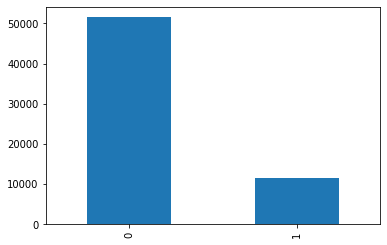

In [0]:

s= all_data['type'].value_counts()
print(s)
s.plot(kind='bar')

### 11.3 Applying LDA (as done before)

In [0]:
#all_data['text_distilled'] = all_data[ 'text_clean' ].apply( lambda x : x.split())
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

def topics(tokenized_words):
    if len( tokenized_words ) == 0 :
      return []
    d = Dictionary([tokenized_words])
    c = [d.doc2bow(tokenized_words)]
    m = LdaModel(c, num_topics=1, id2word=d)
    return list(m.print_topics(num_words=2))
  
all_data['topics'] = all_data['text_clean'].apply(topics)


In [0]:
all_data['topics'].head(5)

0    [(0, 0.036*"government" + 0.036*"group")]
1          [(0, 0.033*"lynch" + 0.022*"cash")]
2         [(0, 0.027*"weiner" + 0.018*"form")]
3      [(0, 0.056*"mueller" + 0.056*"speech")]
4      [(0, 0.024*"insurance" + 0.018*"must")]
Name: topics, dtype: object

In [0]:

def parseTopics(topics):
   output = []
   if len( topics ) >= 1 :
      words = topics[0][1].split( '+' )
   else:
      return []
   for word in words:
       if '*' not in word:
           print(word)
           output.append( word )
       else:
           output.append( word.split('*')[1].replace( '"', '' ) )
   if len( output ) < 2:
      output.append( output[0] )
   if len( output ) != 2:
      return output[:2]
   if not isinstance( output[0], str ) or not isinstance( output[1], str ):
      print( output )
      assert isinstance( output[0], str )
      assert isinstance( output[1], str )
   return output

In [0]:
all_data['topics'] = all_data['topics'].apply(parseTopics)

placement"
placement"
1z"
1z"
1z"
1z"


### 11.4 Encoding Topics using word2vec (Same Practice)

In [0]:
m = Word2Vec( all_data[ 'text_clean' ] )
vector_dim = len(m[list(m.wv.vocab)[0]])

def encodeFirstColumn( topics ):
   if len(topics) == 0:
      return np.zeros( len(m[list(m.wv.vocab)[0]]) ).tolist()
   topic = topics[0].strip()
   if topic in m:
      return m[topic].tolist()
   else:
      return np.zeros( len(m[list(m.wv.vocab)[0]]) ).tolist()
    
def encodeSecondColumn( topics ):
   if len(topics) == 0:
      return np.zeros( len(m[list(m.wv.vocab)[0]]) ).tolist()
   topic = topics[0].strip()
   if topic in m:
      return m[topic].tolist()
   else:
      return np.zeros( len(m[list(m.wv.vocab)[0]]) ).tolist()
    
all_data[ 'topic_0' ] = all_data.topics.apply( encodeFirstColumn )
all_data[ 'topic_1' ] = all_data.topics.apply( encodeSecondColumn )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `__contains__` (Method will be removed in 4.0.0, use self.wv.__contains__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back b

In [0]:
all_data.head(2)

,date,title,text,type,text_clean,topics,topic_0,topic_1
0,2016-10-26,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,0,"[print, pay, back, money, plus, interest, enti...","[government , group]","[0.07933378964662552, -3.009556531906128, -1.6...","[0.07933378964662552, -3.009556531906128, -1.6..."
1,2016-10-29,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,0,"[attorney, general, loretta, lynch, plead, fif...","[lynch , cash]","[0.7625214457511902, -1.818501591682434, 0.073...","[0.7625214457511902, -1.818501591682434, 0.073..."


In [0]:
all_data[ 'date_int' ] = all_data.date.apply( setNumericDate )

In [0]:
all_data.head(1)

,date,title,text,type,text_clean,topics,topic_0,topic_1,date_int
0,2016-10-26,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,0,"[print, pay, back, money, plus, interest, enti...","[government , group]","[0.07933378964662552, -3.009556531906128, -1.6...","[0.07933378964662552, -3.009556531906128, -1.6...",201610


In [0]:
for i in range( vector_dim ):
   all_data[str(i)] = all_data.topic_0.apply( lambda x : select(x, i ) )
    
for i in range( vector_dim ):
   all_data[str(vector_dim + i)] = all_data.topic_0.apply( lambda x : select(x, i ) )

In [0]:
all_data.head(2)

,date,title,text,type,text_clean,topics,topic_0,topic_1,date_int,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,...,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
0,2016-10-26,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,0,"[print, pay, back, money, plus, interest, enti...","[government , group]","[0.07933378964662552, -3.009556531906128, -1.6...","[0.07933378964662552, -3.009556531906128, -1.6...",201610,0.079334,-3.009557,-1.662051,-2.266841,-2.335627,-1.745443,-2.160832,-1.004045,-1.300226,0.072857,0.246503,-2.652552,-1.345933,-0.029735,-1.892621,-0.616135,1.903111,-0.443474,0.594109,-0.809073,-2.115898,0.774787,1.188001,-0.089122,0.384832,0.063867,-0.756649,1.31680,0.272310,-0.028562,-0.194841,...,-0.435395,-1.169180,1.782062,-0.490217,-0.623988,-0.608807,2.066729,-1.075778,1.366600,-0.418619,-0.068477,2.100819,-1.898002,-2.158641,1.862296,0.863017,-0.587883,2.621482,-2.495984,-1.248376,-0.297408,2.934750,-0.172389,1.909907,-0.208789,0.282468,1.512897,2.264486,-5.849609,2.107400,-1.314441,-1.844244,0.617522,1.870771,0.595845,-1.603117,-0.398838,0.313466,1.031952,-0.804625
1,2016-10-29,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,0,"[attorney, general, loretta, lynch, plead, fif...","[lynch , cash]","[0.7625214457511902, -1.818501591682434, 0.073...","[0.7625214457511902, -1.818501591682434, 0.073...",201610,0.762521,-1.818502,0.073615,-1.330492,0.817783,-3.986544,0.044551,1.916255,0.109307,0.713484,-1.854814,-1.629296,-0.625862,-0.882216,-1.479077,1.963957,-0.568883,-3.763935,1.226870,-0.514103,-2.072792,1.518629,0.226536,-0.228273,2.099593,-3.905093,-0.654460,-1.16409,-0.745293,0.241756,0.838447,...,0.878114,-2.696398,1.805166,0.338251,-1.008294,-0.261054,0.079697,-0.127949,1.687837,0.449857,-0.512068,-0.083967,-0.689740,-1.272833,1.194792,0.531286,-2.780781,-3.009634,-0.214214,0.063288,-0.460120,-0.614793,-1.011238,0.448185,-0.766329,0.811769,-2.268639,-0.971313,0.554113,-0.026196,-0.564342,-0.529042,0.175070,0.930861,0.466476,-0.766497,-0.361554,0.043191,-2.592243,1.747221


### 11.5 Generating coverage score

In [0]:
keys = [str(i) for i in range(200)]
X_Actual = all_data[['date_int'] + keys ]
Y_Predict = f_cov.predict(X_Actual)

In [0]:
all_data['Coverage'] = Y_Predict 

In [0]:
sorted(Y_Predict, reverse=True )[:10]

[20, 20, 17, 17, 17, 17, 17, 16, 9, 9]

In [0]:
all_data.type.value_counts()

0    51507
1    11492
Name: type, dtype: int64

0    51507
1    11492
Name: type, dtype: int64


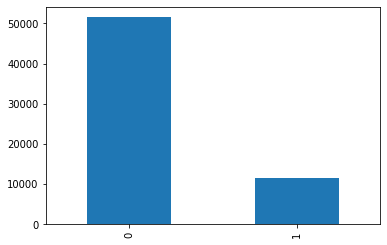

In [0]:
s= all_data['type'].value_counts()
print(s)
s.plot(kind='bar')

In [0]:
all_data.head(2)

,date,title,text,type,text_clean,topics,topic_0,topic_1,date_int,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,...,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,Coverage
0,2016-10-26,Muslims BUSTED: They Stole Millions In Gov’t B...,Print They should pay all the back all the mon...,0,"[print, pay, back, money, plus, interest, enti...","[government , group]","[0.07933378964662552, -3.009556531906128, -1.6...","[0.07933378964662552, -3.009556531906128, -1.6...",201610,0.079334,-3.009557,-1.662051,-2.266841,-2.335627,-1.745443,-2.160832,-1.004045,-1.300226,0.072857,0.246503,-2.652552,-1.345933,-0.029735,-1.892621,-0.616135,1.903111,-0.443474,0.594109,-0.809073,-2.115898,0.774787,1.188001,-0.089122,0.384832,0.063867,-0.756649,1.31680,0.272310,-0.028562,-0.194841,...,-1.169180,1.782062,-0.490217,-0.623988,-0.608807,2.066729,-1.075778,1.366600,-0.418619,-0.068477,2.100819,-1.898002,-2.158641,1.862296,0.863017,-0.587883,2.621482,-2.495984,-1.248376,-0.297408,2.934750,-0.172389,1.909907,-0.208789,0.282468,1.512897,2.264486,-5.849609,2.107400,-1.314441,-1.844244,0.617522,1.870771,0.595845,-1.603117,-0.398838,0.313466,1.031952,-0.804625,1
1,2016-10-29,Re: Why Did Attorney General Loretta Lynch Ple...,Why Did Attorney General Loretta Lynch Plead T...,0,"[attorney, general, loretta, lynch, plead, fif...","[lynch , cash]","[0.7625214457511902, -1.818501591682434, 0.073...","[0.7625214457511902, -1.818501591682434, 0.073...",201610,0.762521,-1.818502,0.073615,-1.330492,0.817783,-3.986544,0.044551,1.916255,0.109307,0.713484,-1.854814,-1.629296,-0.625862,-0.882216,-1.479077,1.963957,-0.568883,-3.763935,1.226870,-0.514103,-2.072792,1.518629,0.226536,-0.228273,2.099593,-3.905093,-0.654460,-1.16409,-0.745293,0.241756,0.838447,...,-2.696398,1.805166,0.338251,-1.008294,-0.261054,0.079697,-0.127949,1.687837,0.449857,-0.512068,-0.083967,-0.689740,-1.272833,1.194792,0.531286,-2.780781,-3.009634,-0.214214,0.063288,-0.460120,-0.614793,-1.011238,0.448185,-0.766329,0.811769,-2.268639,-0.971313,0.554113,-0.026196,-0.564342,-0.529042,0.175070,0.930861,0.466476,-0.766497,-0.361554,0.043191,-2.592243,1.747221,1


### 11.6 Exporting csv file

In [0]:
all_data_to_export = all_data[["title", "Coverage"]]
all_data_to_export.to_csv('all_data_coverage_condensed.csv', index=False )

Commenting file download

In [0]:
from google.colab import files

#files.download('all_data_coverage_condensed.csv')

### 11.7 Plotting results for visualization

Text(0, 0.5, 'Count')

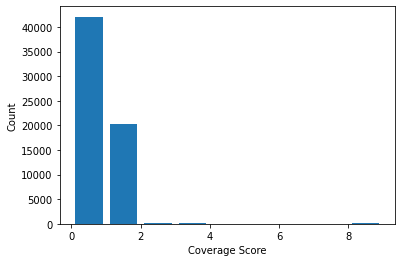

In [0]:
import matplotlib.pyplot as plt

bins = range(10)
plt.hist(all_data.Coverage, bins, histtype='bar', rwidth=0.8, cumulative=False )
plt.xlabel( "Coverage Score" )
plt.ylabel( "Count")

Text(0, 0.5, 'Coverage Score')

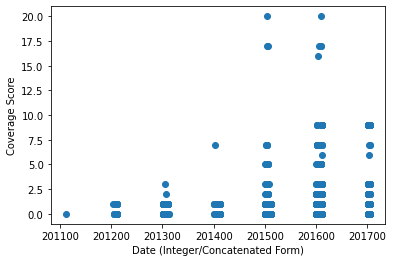

In [0]:
plt.scatter(all_data.date_int, all_data.Coverage )
plt.xlabel( "Date (Integer/Concatenated Form)" )
plt.ylabel( "Coverage Score" )

## **Reference**

* 1. https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21